# Lapped Transforms for Images

**Author:** Sushmita Raj

**Date:** 2024-12-06  

**Description:** (WIP) Comparing DCT and MDCT for images

In [1]:
from google.colab import output
output.enable_custom_widget_manager()

In [2]:
# Import dependencies
! pip install ipympl
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.fft as sfft
# from demo_utils import colourT, dcti, idcti, mdcti, imdcti, yuvStacktoRGB, printQualityStats, QuantizeImage, DeQuantizeImage

In [3]:
def padi(image, block_size=8):
    """
    Pads an image so its dimensions are multiples of the block size.

    Parameters:
    - image: numpy array representing the 2D image
    - block_size: Size of the blocks (default is 8).

    Returns:
    - padded_image: The padded image with dimensions that are multiples of block_size.
    """
    # Get the original height and width
    height, width = image.shape
    # Calculate the padding required for both height and width
    pad_height = (block_size - height % block_size) if height % block_size != 0 else 0
    pad_width = (block_size - width % block_size) if width % block_size != 0 else 0
    # Pad the image with zeros (black padding)
    padded_image = np.pad(image, ((0, pad_height), (0, pad_width)), mode='constant', constant_values=0)
    return padded_image

def unpadi(image, original_shape):
    """
    Removes padding from an image, restoring it to the original dimensions.

    Parameters:
    - image: numpy array representing the 3-D (channels, height, width) coloured padded image.
    - original_shape: Tuple containing the original height and width of the image.

    Returns:
    - cropped_image: The image cropped back to its original dimensions.
    """
    cropped_image = image[:,:original_shape[1], :original_shape[2]]
    return cropped_image

In [4]:
# 2-D DCT using cv2
def dctii(image, N=8):
    """
    Applies a 2D Discrete Cosine Transform (DCT-II) to an image in a blockwise manner.
    Use cv2.dct as it is optimized for handling images efficiently

    Parameters:
    - image: 2D numpy array representing the grayscale image.
    - N: Block size for the DCT (default is 8x8 blocks).

    Returns:
    - dct_image: The transformed image with the same shape as the input image.
    """
    # Ensure the dimensions are divisible by block_size
    assert image.shape[0] % N == 0 and image.shape[1] % N == 0, "Image dimensions must be divisible by block size"
    # Initialize the output array
    dct_image = np.zeros_like(image, dtype=float)

    # Process each block
    for i in range(0, image.shape[0], N):
        for j in range(0, image.shape[1], N):
            # Extract the block
            block = image[i:i+N, j:j+N]
            # Apply 2D DCT-IV to the block
            # block -= 128
            dct_block =cv2.dct(block)
            # Place the transformed block in the output image
            dct_image[i:i+N, j:j+N] = dct_block

    return dct_image

def idctii(dct_image, block_size=8):
    """
    Applies a 2D Inverse Discrete Cosine Transform (IDCT-II) to a blockwise DCT image.
    Use cv2.idct as it is optimized for handling images efficiently

    Parameters:
    - dct_image: 2D numpy array representing the DCT-transformed image.
    - block_size: Block size for the IDCT (default is 8x8 blocks).

    Returns:
    - reconstructed_image: The reconstructed image after IDCT with the same shape as dct_image.
    """
    h, w = dct_image.shape
    assert h % block_size == 0 and w % block_size == 0, "Image dimensions must be divisible by block_size"
    reconstructed_image = np.zeros_like(dct_image, dtype=float)
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = dct_image[i:i+block_size, j:j+block_size]
            idct_block = cv2.idct(block)
            # idct_block -= 128
            reconstructed_image[i:i+block_size, j:j+block_size] = idct_block
    return reconstructed_image

In [5]:
def mdct(signal, N=8, window=None):
    """
    Perform the Modified Discrete Cosine Transform (MDCT) on a signal.

    Parameters:
    - signal (numpy array): Input 1D signal.
    - N (int): Block size for the MDCT (default is 8). Must be even.
    - window (numpy array or None): Optional window function of size 2*N.
      If None, no windowing is applied.

    Returns:
    - X (numpy array): MDCT coefficients as a 2D array, where each row represents
      the MDCT of a block of the input signal.
    """
    # Calculate the number of blocks (M) and half the block size (N/2)
    M = int(signal.shape[0] / N)  # Number of non-overlapping blocks
    halfN = int(N / 2)

    # Pad the signal with zeros to ensure full block coverage
    # Padding length is N on both sides
    x_padded = np.pad(signal, pad_width=N, mode='constant', constant_values=0)

    # Split the padded signal into M+1 overlapping blocks of size 2*N
    blocks = np.array([x_padded[i:i + 2 * N]
                       for i in range(0, len(x_padded) - 2 * N + 1, N)])

    # Apply the provided window function to each block, if specified
    # If no window is provided, the blocks remain unchanged
    winblocks = (window * blocks) if window is not None else blocks

    # Initialize an array for storing the overlapped and transformed blocks
    lapblocks = np.zeros((M + 1, N))

    # Overlap-Add Process: Combine overlapping portions of blocks
    for i in range(M + 1):
        # Split the current block into four equal parts
        a = winblocks[i, 0:halfN]         # First quarter
        b = winblocks[i, halfN:N]        # Second quarter
        c = winblocks[i, N:3*halfN]      # Third quarter
        d = winblocks[i, 3*halfN:2*N]    # Fourth quarter

        # Reverse the second and third quarters
        br = b[::-1]  # Reverse of `b`
        cr = c[::-1]  # Reverse of `c`

        # Debug print to observe the segments if you wish
        # print("a br cr d", a, br, cr, d)

        # Combine the segments using the MDCT overlap-add equations
        A = -cr - d  # Compute the left-half coefficients
        B = a - br   # Compute the right-half coefficients

        # Concatenate A and B to form the current overlapped block
        lapblocks[i] = np.concatenate((A, B))

    # Apply the Type-4 Discrete Cosine Transform (DCT-IV) to each block
    # The result is a 2D array where each row is the MDCT of a block
    X = np.zeros((M + 1, N))
    for i in range(M + 1):
        X[i] = sfft.dct(lapblocks[i], type=4, norm="ortho")

    if(window is None):
        X *= np.sqrt(1/2)

    X_f = X.flatten()

    # Return the MDCT coefficients
    return X_f

def imdct(subbands, N=8, window=None):
    """
    Perform the Inverse Modified Discrete Cosine Transform (IMDCT) on a set of
    MDCT coefficients.

    Parameters:
    - subbands (numpy array): A 2D array of MDCT coefficients, where each row
        corresponds to the MDCT of a signal block.
    - N (int): Block size used during the MDCT (default is 8).
        Must be an even integer.
    - window (numpy array or None): An optional window function of length 2*N.
        If None, no(/rectangular) windowing is applied during reconstruction

    Returns:
    - x_recon (numpy array): The reconstructed 1D signal from the IMDCT process
    """
    # Determine the number of overlapping blocks (M+1) from the input subbands
    M = int(subbands.shape[0]/N) - 1  # Non-overlapping blocks, minus 1 due to overlap
    halfN = int(N / 2)         # Half the block size, used in segmenting blocks

    subbands = np.reshape(subbands, (M+1,N))
    # Initialize an array to store the output of the Inverse DCT-IV (IDCT-IV)
    # IDCT-IV is applied block-by-block to the MDCT coefficients (subbands)
    Xd = np.zeros((M + 1, N))
    for i in range(M + 1):
        # Apply IDCT-IV,
        # IDCT-IV is mathematically equivalent to DCT-IV (self-inverse)
        Xd[i] = sfft.dct(subbands[i], type=4, norm="ortho")

    # Initialize arrays for intermediate reconstruction steps
    z = np.zeros((M + 1, 2 * N))  # overlapped blocks in the time domain

    # Reconstruct the overlapping blocks using the IMDCT algorithm
    for i in range(M + 1):
        # Split the IDCT-IV output into two halves
        A = Xd[i, halfN:]                # Second half
        B = -np.flip(Xd[i, halfN:])      # Flipped and negated second half
        C = -np.flip(Xd[i, :halfN])      # Flipped and negated first half
        D = -Xd[i, :halfN]               # First half, negated

        # Concatenate the four parts to form the reconstructed overlapped block
        z[i, :] = np.concatenate((A, B, C, D))

    # Apply the synthesis window if provided, otherwise keep blocks unchanged
    winz = (window * z) if window is not None else z

    # Initialize the final reconstructed signal blocks
    x_recon = np.zeros((M, N))  # the M original non-overlapping blocks

    # Perform overlap-add synthesis to reconstruct each block
    for i in range(M):
        # Combine the overlapping portions of consecutive blocks
        x_recon[i, :] = winz[i, N:] + winz[i + 1, :N]

    if(window is None):
        x_recon *= np.sqrt(1/2)

    # Flatten the 2D array of reconstructed blocks into a single 1D signal
    x_recon = x_recon.flatten()

    return x_recon

In [6]:
# Util functions to apply the 2-D MDCT to images using the 1-D MDCT


def mdct1(x, N, window):
    M = int(x.shape[1]//N) # Number of non-overlapping blocks
    nBlocks = x.shape[0]
    outlen = N*(M+1)

    X = np.zeros((nBlocks,outlen))

    for ri in range(nBlocks):
        X[ri] = np.reshape(mdct(x[ri], N, window), outlen)

    return X

# Split the image into 1-D vectors to apply the 1-D MDCT
def mdct2(x, N, window=None, showAll=False):
    xr_mdct = mdct1(x, N, window)
    x_mdct = mdct1(xr_mdct.T, N, window).T

    if showAll:
        # Display original signal
        print("x", x.shape, x)
        plt.imshow(x, cmap='viridis', interpolation='nearest')
        plt.colorbar()  # Show color scale
        plt.title('Original')
        plt.show()

        # Display MDCT along rows
        plt.imshow(xr_mdct, cmap='viridis', interpolation='nearest')
        plt.colorbar()  # Show color scale
        plt.title('MDCT along rows')
        plt.show()

        # Display MDCT along rows and columns
        print("X MDCT",x_mdct.shape, x_mdct)
        plt.imshow(x_mdct, cmap='viridis', interpolation='nearest')
        plt.colorbar()  # Show color scale
        plt.title('MDCT along rows and columns')
        plt.show()

    return x_mdct

def imdct1(X, N, window):
    M = int(X.shape[1] // N) - 1 # Number of non-overlapping blocks
    nBlocks = X.shape[0]
    outlen = N*M

    x = np.zeros((nBlocks,outlen))

    for ri in range(nBlocks):
        x[ri] = np.reshape(imdct(X[ri], N, window), outlen)

    return x

def imdct2(X, N, window=None, showAll=False):
    xc_imdct = imdct1(X.T, N, window).T
    x_imdct = imdct1(xc_imdct, N, window)

    if showAll:
        # Display original signal
        plt.imshow(X, cmap='viridis', interpolation='nearest')
        plt.colorbar()  # Show color scale
        plt.title('Original Subbands')
        plt.show()

        # IMDCT along columns
        plt.imshow(xc_imdct, cmap='viridis', interpolation='nearest')
        plt.colorbar()  # Show color scale
        plt.title('IMDCT along columns')
        plt.show()

        # IMDCT along columns and rows
        print("X IMDCT",x_imdct.shape, x_imdct)
        plt.imshow(x_imdct, cmap='viridis', interpolation='nearest')
        plt.colorbar()  # Show color scale
        plt.title('IMDCT along columns and rows')
        plt.show()

    return x_imdct

In [7]:
from skimage.metrics import structural_similarity as ssim

def mdcti(image):
    N=8
    window = np.sin((np.pi/(2*N)*((np.arange(2*N))+0.5)))
    return mdct2(image, N, window)

def imdcti(x):
    N=8
    window = np.sin((np.pi/(2*N)*((np.arange(2*N))+0.5)))
    return imdct2(x, N, window)

def dcti(image):
    return dctii(image, N=8)

def idcti(image):
    return idctii(image, 8)

def colourT(image, func):
    return np.stack((func(image[0]), func(image[1]), func(image[2])))

def yuvStacktoRGB(image):
    return cv2.cvtColor(np.transpose(((1.-image) * 255).astype(np.uint8), (1, 2, 0)), cv2.COLOR_YUV2RGB)

def printQualityStats(x, x_recon):
    # Mean Absolute Error (MAE)
    mae = np.mean(np.abs(x - x_recon))
    print(f"Mean Absolute Error (MAE): {mae}")

    # Mean Squared Error (MSE)
    mse = np.mean((x - x_recon) ** 2)
    print(f"Mean Squared Error (MSE): {mse}")

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    # Peak Signal-to-Noise Ratio (PSNR)
    max_val = np.max(x)  # Assuming the original signal defines the max possible value
    psnr = 20 * np.log10(max_val / rmse) if rmse > 0 else float('inf')
    print(f"Peak Signal-to-Noise Ratio (PSNR): {psnr} dB")

    min = np.min(x)
    max = np.max(x)
    xn = np.array((x - min) / (max - min))

    min = np.min(x_recon)
    max = np.max(x_recon)
    xrn = np.array((x_recon - min) / (max - min))

    y_ssim,_ = ssim(xn[0], xrn[0], data_range=1, full=True)
    u_ssim,_ = ssim(xn[1], xrn[1], data_range=1, full=True)
    v_ssim,_ = ssim(xn[2], xrn[2], data_range=1, full=True)

    ssim_value = ( y_ssim + u_ssim + v_ssim ) / 3 # 1 = identical, 0 = completely different
    print("SSIM ", ssim_value)

def quantize_blocks(channel, Q):
    h, w = channel.shape
    block_size = 8
    quantized = np.zeros_like(channel, dtype=np.float32)

    # Process each 8x8 block
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            # Quantize the DCT coefficients
            quantized[i:i+block_size, j:j+block_size] = np.divide(channel[i:i+block_size, j:j+block_size] , Q)
    return quantized

def QuantizeImage(image, Q_Y, Q_UV):
    Yq = quantize_blocks(image[0], Q_Y)
    Uq = quantize_blocks(image[1], Q_UV)
    Vq = quantize_blocks(image[2], Q_UV)

    return np.stack((Yq, Uq, Vq))

def dequantize_blocks(channel, Q):
    h, w = channel.shape
    block_size = 8
    dequantized = np.zeros_like(channel, dtype=np.float32)

    # Process each 8x8 block
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            # De Quantize the DCT coefficients
            dequantized[i:i+block_size, j:j+block_size] = np.multiply(channel[i:i+block_size, j:j+block_size] , Q)

    return dequantized

def DeQuantizeImage(image, Q_Y, Q_UV):
    Yq = dequantize_blocks(image[0], Q_Y)
    Uq = dequantize_blocks(image[1], Q_UV)
    Vq = dequantize_blocks(image[2], Q_UV)

    return np.stack((Yq, Uq, Vq))

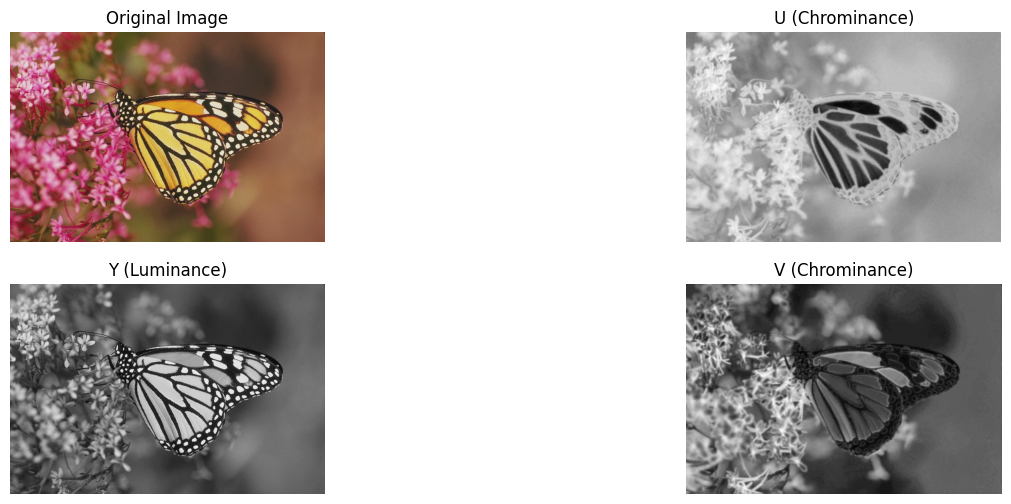

In [8]:
# Read the image
# Load the image
image = cv2.imread('monarch.tif')

# Check if the image is loaded successfully
if image is None:
    raise ValueError("Failed to load the image. Check the file path or format.")

# Convert BGR (OpenCV default) to RGB for correct color display
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Convert RGB to YUV
image_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)

# Separate Y, U, and V components
Y, U, V = cv2.split(image_yuv)

# Plot the original image and the YUV components
plt.figure(figsize=(16, 6))

# Original image
plt.subplot(2, 2, 1)
plt.title('Original Image')
plt.imshow(image_rgb)
plt.axis('off')

# Y Component
plt.subplot(2, 2, 3)
plt.title('Y (Luminance)')
plt.imshow(Y, cmap='gray')
plt.axis('off')

# U Component
plt.subplot(2, 2, 2)
plt.title('U (Chrominance)')
plt.imshow(U, cmap='gray')
plt.axis('off')

# V Component
plt.subplot(2, 2, 4)
plt.title('V (Chrominance)')
plt.imshow(V, cmap='gray')
plt.axis('off')

plt.show()


In [9]:
img = np.stack((Y, U, V))

# Pad the image if needed
original_shape = img.shape
image = colourT(img, padi)

DCT max min 1792.0 -575.0
DCT max min 1927.0 -671.0


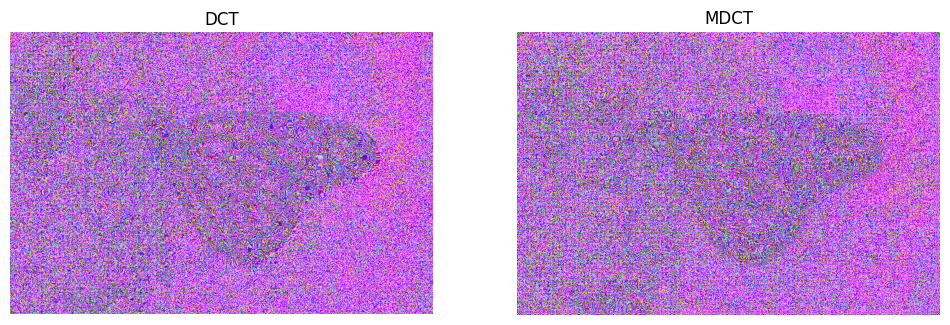

In [10]:
# DCT
dct_image  = np.round(colourT(image.astype(np.float32), dcti))
print("DCT max min", np.max(dct_image), np.min(dct_image))

# MDCT
mdct_image = np.round(colourT(image.astype(np.float32), mdcti))
print("DCT max min", np.max(mdct_image), np.min(mdct_image))

# Plot the original image and the YUV components
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title('DCT')
plt.imshow(yuvStacktoRGB(dct_image))
plt.axis('off')
# Plot the original image and the YUV components
plt.subplot(1,2,2)
plt.title('MDCT')
plt.imshow(yuvStacktoRGB(mdct_image))
plt.axis('off')
plt.show()


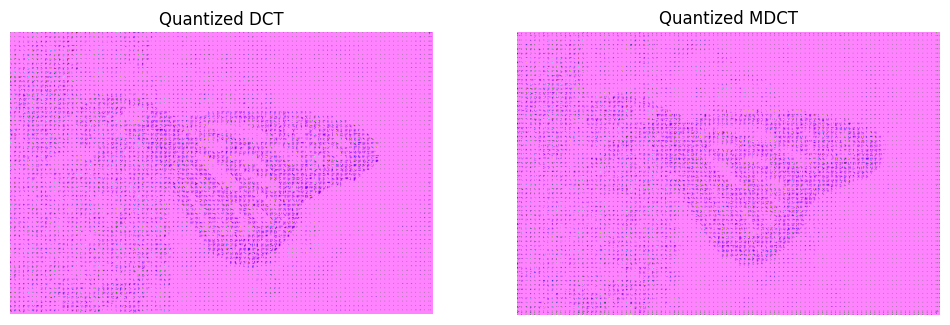

In [11]:
# Quantization
# Standard JPEG Luminance Quantization Matrix
Q_Y = np.array([
        [16, 11, 10, 16, 24,  40,  51,  61],
        [12, 12, 14, 19, 26,  58,  60,  55],
        [14, 13, 16, 24, 40,  57,  69,  56],
        [14, 17, 22, 29, 51,  87,  80,  62],
        [18, 22, 37, 56, 68, 109, 103,  77],
        [24, 35, 55, 64, 81, 104, 113,  92],
        [49, 64, 78, 87,103, 121, 120, 101],
        [72, 92, 95, 98,112, 100, 103,  99]
])

# Standard JPEG Chrominance Quantization Matrix
Q_UV = np.array([
        [17, 18, 24, 47, 99, 99, 99, 99],
        [18, 21, 26, 66, 99, 99, 99, 99],
        [24, 26, 56, 99, 99, 99, 99, 99],
        [47, 66, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99]
])
# QF = 50
#q_dct_image = quantize(dct_image, QF=QF)
#q_mdct_image = quantize(mdct_image, QF=QF)
q_dct_image = np.round(QuantizeImage(dct_image, Q_Y, Q_UV))
q_mdct_image = np.round(QuantizeImage(mdct_image, Q_Y, Q_UV))

# Flat Quantization
# qStep = 10
# q_dct_image = np.round(dct_image / qStep)
# q_mdct_image = np.round(mdct_image / qStep)


# Plot the original image and the YUV components
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title('Quantized DCT')
plt.imshow(yuvStacktoRGB(q_dct_image))
plt.axis('off')
# Plot the original image and the YUV components
plt.subplot(1,2,2)
plt.title('Quantized MDCT')
plt.imshow(yuvStacktoRGB(q_mdct_image))
plt.axis('off')
plt.show()

In [12]:
# DCT
# Calculate theoretical bits per pixel
# Calculate the histogram of the image
histogram, bins = np.histogram(q_dct_image.flatten(), bins=256, range=[np.min(q_dct_image), np.max(q_dct_image)])
# Normalize the histogram to get the probability distribution
histogram = histogram / histogram.sum()
# Calculate the entropy
entropy = -np.sum(histogram * np.log2(histogram + 1e-10))  # Adding small epsilon to avoid log(0)
print(f"DCT Entropy: {entropy:.4f} bits per pixel")

# MDCT
# Calculate theoretical bits per pixel
# Calculate the histogram of the image
histogram, bins = np.histogram(q_mdct_image.flatten(), bins=256, range=[np.min(q_mdct_image), np.max(q_mdct_image)])
# Normalize the histogram to get the probability distribution
histogram = histogram / histogram.sum()
# Calculate the entropy
entropy = -np.sum(histogram * np.log2(histogram + 1e-10))  # Adding small epsilon to avoid log(0)
print(f"MDCT Entropy: {entropy:.4f} bits per pixel")

DCT Entropy: 0.6152 bits per pixel
MDCT Entropy: 0.6123 bits per pixel


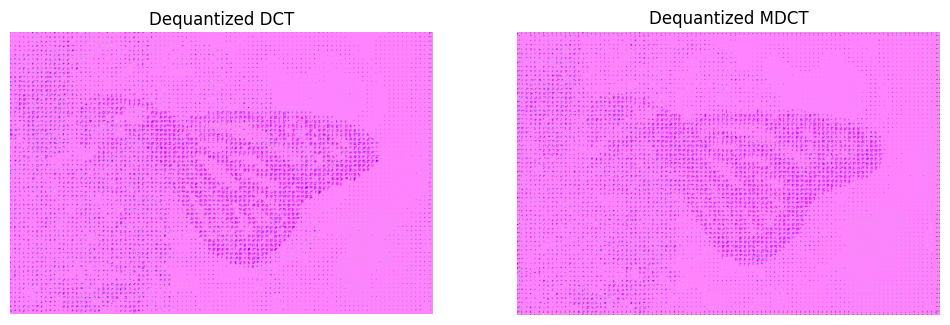

In [13]:
# De-quantize
dq_dct_image = np.round(DeQuantizeImage(q_dct_image, Q_Y, Q_UV))# dequantize(q_dct_image, QF=QF, divFactor=divFactor)
dq_mdct_image = np.round(DeQuantizeImage(q_mdct_image, Q_Y, Q_UV)) # dequantize(q_mdct_image, QF=QF, divFactor=divFactor)

# Flat quantization
# dq_dct_image = np.round(q_dct_image * qStep)
# dq_mdct_image = np.round(q_mdct_image * qStep)

# Quantization with a quality factor
#dq_dct_image = dequantize(q_dct_image, QF=QF)
#dq_mdct_image = dequantize(q_mdct_image, QF=QF)

# Plot the original image and the YUV components
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title('Dequantized DCT')
plt.imshow(yuvStacktoRGB(dq_dct_image))
plt.axis('off')
# Plot the original image and the YUV components
plt.subplot(1,2,2)
plt.title('Dequantized MDCT')
plt.imshow(yuvStacktoRGB(dq_mdct_image))
plt.axis('off')
plt.show()

In [18]:
# IDCT
idct_image = unpadi(np.round(colourT(dq_dct_image.astype(np.float32), idcti)), original_shape)

# IMDCT
imdct_image = unpadi(np.round(colourT(dq_mdct_image.astype(np.float32), imdcti)), original_shape)

%matplotlib notebook
# Plot the original image and the YUV components
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title('IDCT')
plt.imshow(yuvStacktoRGB(idct_image))
#plt.axis('on')
# Plot the original image and the YUV components
plt.subplot(1,2,2)
plt.title('IMDCT')
plt.imshow(yuvStacktoRGB(imdct_image))
#plt.axis('on')
plt.show()


<IPython.core.display.Javascript object>

Support for third party widgets will remain active for the duration of the session. To disable support:

In [15]:
#from google.colab import output
#output.disable_custom_widget_manager()

In [16]:
# Quality
print("DCT quality Stats")
printQualityStats(image, idct_image)
print("MDCT quality Stats")
printQualityStats(image, imdct_image)

DCT quality Stats
Mean Absolute Error (MAE): 1.8135155571831598
Mean Squared Error (MSE): 8.831427680121529
Root Mean Squared Error (RMSE): 2.971771808218378
Peak Signal-to-Noise Ratio (PSNR): 38.32301251846968 dB
SSIM  0.9563278235843701
MDCT quality Stats
Mean Absolute Error (MAE): 1.7848697238498263
Mean Squared Error (MSE): 8.492426554361979
Root Mean Squared Error (RMSE): 2.914176822768649
Peak Signal-to-Noise Ratio (PSNR): 38.49300369109665 dB
SSIM  0.9580677260148512


In [17]:
# Interactive Zoom
